In [1]:
import urllib
import re
import numpy as np
import pandas as pd
from astropy.io import ascii
from astropy.table import Table, QTable, Column
from astroquery.sdss import SDSS

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def makeSDSS_post_request(sSQL_query,DR_num):
    ''' function based on work by Aaron Deich '''
    values = {'cmd': sSQL_query, 'format': 'csv'}
    data = urllib.parse.urlencode(values)
    if DR_num <= 7 :
        sURL = 'http://cas.sdss.org/dr7/en/tools/search/x_sql.asp'
        first_character = 0
    else : 
        sURL = 'http://skyserver.sdss3.org/public/en/tools/search/x_sql.aspx'
        first_character = 8 # to eliminate the line that says #Table1
    response = urllib.request.urlopen(sURL+'?%s' % data)
    return str(response.read()[first_character:])

In [3]:
sdss_dr7 = pd.read_csv("confirmed_compact_galaxies_dr7.csv")
columnsNamesArr = sdss_dr7.columns.values
column_names = list(columnsNamesArr)
print(column_names[1:])

['RA', 'DEC', 'mass', 'host', 'log_ml', 'log_l', 'log_m', 'host_mass', 'host_ra', 'host_dec', 'host_distance', 'objid']


In [4]:
host_known_dr7 = sdss_dr7['host']
ra_host_dr7 = sdss_dr7['host_ra']
dec_host_dr7 = sdss_dr7['host_dec']
host_dist_dr7 = sdss_dr7['host_distance']
objid_known_dr7 = sdss_dr7['objid']

In [5]:
# Query list around the host of each compact galaxy to find the compact galaxy, and any confirmed contaminants via NED search
querylist_dr7=[]
radial_dist = 150 # kpc originally 100 testing at  150 for now. look at mayes to find search radius
max_size = 500 # original was 500 pc
for i in range(len(objid_known_dr7)):
    ra = ra_host_dr7[i]
    dec = dec_host_dr7[i]
    arcmin =  radial_dist/(host_dist_dr7[i]*1000)  *360/(2*np.pi)*3600/60 # arcmin
    arcsec_to_pc = host_dist_dr7[i] * 1e6 / 3600 * 2 * np.pi / 360
    mag_calc = 5*np.log10((host_dist_dr7[i]*1e6/10))
    
    query_temp = f"select p.objID, p.ra, p.dec, p.g, p.i, p.r, p.u, p.z, p.type, p.petroR50_r, p.petroR90_r, p.fracDeV_r, p.deVRad_r, p.expRad_r, z1.z as photo_z, p.expAB_r\
        from photoObj as p JOIN Photoz as z1 on p.objID = z1.objID, dbo.fGetNearbyObjEq({ra},{dec},{arcmin}) as n \
        where p.objID = n.objID and p.type = 3 and p.g - p.r BETWEEN 0.35 and 1 and p.g - p.i BETWEEN 0.65 and 1.5 and p.u - p.z BETWEEN 2.2 and 4 and p.g - p.z BETWEEN 1 and 1.85 and p.u - p.g BETWEEN 1 and 2.4 and p.r - {mag_calc} > -18.5 and p.r - {mag_calc} < -12 and (p.fracDeV_r *  p.deVRad_r + (1 - p.fracDev_r) * p.expRad_r) * {arcsec_to_pc} < {max_size} and p.fracDev_r > 0.5 and z1.z < 0.15 and z1.z > -0.1 "
    querylist_dr7.append(query_temp)
print(querylist_dr7[1])

select p.objID, p.ra, p.dec, p.g, p.i, p.r, p.u, p.z, p.type, p.petroR50_r, p.petroR90_r, p.fracDeV_r, p.deVRad_r, p.expRad_r, z1.z as photo_z, p.expAB_r        from photoObj as p JOIN Photoz as z1 on p.objID = z1.objID, dbo.fGetNearbyObjEq(187.7059308,12.39112329,31.442805830350053) as n         where p.objID = n.objID and p.type = 3 and p.g - p.r BETWEEN 0.35 and 1 and p.g - p.i BETWEEN 0.65 and 1.5 and p.u - p.z BETWEEN 2.2 and 4 and p.g - p.z BETWEEN 1 and 1.85 and p.u - p.g BETWEEN 1 and 2.4 and p.r - 31.07421924023849 > -18.5 and p.r - 31.07421924023849 < -12 and (p.fracDeV_r *  p.deVRad_r + (1 - p.fracDev_r) * p.expRad_r) * 79.50944370196389 < 500 and p.fracDev_r > 0.5 and z1.z < 0.15 and z1.z > -0.1 


In [6]:
# make empty lists and run the query and pull the data into the specific lists and convert to array 
objid_list_dr7 = [] 
ra_list_dr7 = [] 
dec_list_dr7 = []
obj_per_search_dr7 = []
petro_r50_list_dr7 = []
petro_r90_list_dr7 = []
fracdev_list_dr7 = []
fracexp_list_dr7 = []
devrad_list_dr7 = []
exprad_list_dr7 = []
r_mag_list_dr7 = []
g_mag_list_dr7 = []
i_mag_list_dr7 = []
u_mag_list_dr7 = []
z_mag_list_dr7 = []
z_list_dr7 = []
axis_ratio_list_dr7 = []

for i in range(len(objid_known_dr7)):
    sdss_data_string = makeSDSS_post_request(querylist_dr7[i],7)
#     print(sdss_data_string)
#     print((re.split(r'[,\\n]',sdss_data_string)))
    N_col = 16
    # note the N_Col+1 instances below are because of extra whitespaces :
    sdss_data = np.array(re.split(r'[,\\n]',sdss_data_string)[N_col+1:-1]).reshape(-1,N_col+1)[:,:N_col]
#     print(sdss_data)
#     print('index:', i)
        
    objid_list_dr7.extend(sdss_data[:,0].astype(np.int64))  
    ra_list_dr7.extend(sdss_data[:,1].astype('float'))
    dec_list_dr7.extend(sdss_data[:,2].astype('float')) 
    petro_r50_list_dr7.extend(sdss_data[:,9].astype('float'))
    petro_r90_list_dr7.extend(sdss_data[:,10].astype('float'))
    fracdev_list_dr7.extend(sdss_data[:,11].astype('float'))
    fracexp_list_dr7.extend(1 - sdss_data[:,11].astype('float'))
    devrad_list_dr7.extend(sdss_data[:,12].astype('float'))
    exprad_list_dr7.extend(sdss_data[:,13].astype('float'))
    r_mag_list_dr7.extend(sdss_data[:,5].astype('float'))
    g_mag_list_dr7.extend(sdss_data[:,3].astype('float'))
    i_mag_list_dr7.extend(sdss_data[:,4].astype('float'))
    u_mag_list_dr7.extend(sdss_data[:,6].astype('float'))
    z_mag_list_dr7.extend(sdss_data[:,7].astype('float'))
    z_list_dr7.extend(sdss_data[:,14].astype('float'))
    axis_ratio_list_dr7.extend(sdss_data[:,15].astype('float'))
    obj_per_search_dr7.append((len(sdss_data[:,0].astype(np.int64))))
    

objid_dr7 = np.array(objid_list_dr7)
ra_dr7 = np.array(ra_list_dr7)
dec_dr7 = np.array(dec_list_dr7)
petro_r50_dr7 = np.array(petro_r50_list_dr7)
petro_r90_dr7 = np.array(petro_r90_list_dr7)
fracdev_dr7 = np.array(fracdev_list_dr7) 
fracexp_dr7 = np.array(fracexp_list_dr7) 
devrad_dr7 = np.array(devrad_list_dr7) 
exprad_dr7 = np.array(exprad_list_dr7) 
r_mag_dr7 = np.array(r_mag_list_dr7) 
g_mag_dr7 = np.array(g_mag_list_dr7)
i_mag_dr7 = np.array(i_mag_list_dr7)
u_mag_dr7 = np.array(u_mag_list_dr7)
z_mag_dr7 = np.array(z_mag_list_dr7)
g_i_mag_dr7 = g_mag_dr7 - i_mag_dr7
z_dr7 = np.array(z_list_dr7)
axis_ratio_dr7 = np.array(axis_ratio_list_dr7)

In [7]:
#calculate size of objects given distance of the host galaxy and abs magnitude
a0 = 0
r_pc_list_dr7 = []
mv_r_list_dr7 = []
distance_list_dr7 = []
host_galaxy_list_dr7 = []

for i in range(len(objid_known_dr7)):
    a1 = a0 + int(obj_per_search_dr7[i])
    
    #size
    r50_arcsec_dr7 = fracdev_dr7[a0:a1]*devrad_dr7[a0:a1] + fracexp_dr7[a0:a1]*exprad_dr7[a0:a1] 
    r50_pc_dr7 = r50_arcsec_dr7*host_dist_dr7[i]*1e6/3600 * 2*np.pi /360
    r_pc_list_dr7.extend(r50_pc_dr7)
    
    #abs mag of obj   Mv = m - 2.5 log[ (d/10)^2 ]. absolute magnitude of r ,d should be in parsec
    mv_r_temp_dr7 = r_mag_dr7[a0:a1] - 5*np.log10((host_dist_dr7[i]*1e6/10))
    mv_r_list_dr7.extend(mv_r_temp_dr7)
    
    #distance of galaxies according to the host galaxies
    obj_search_dr7 = obj_per_search_dr7[i]
    distance_list_dr7.extend([host_dist_dr7[i]]*obj_search_dr7)
    
    #host galaxy
    host_galaxy_list_dr7.extend([host_known_dr7[i]]*obj_search_dr7)
    
    a0 = a1
    
distance_dr7 = np.array(distance_list_dr7)
mv_r_dr7 = np.array(mv_r_list_dr7)
r_pc_dr7 = np.array(r_pc_list_dr7)
host_galaxy_list_dr7 = np.array(host_galaxy_list_dr7)

In [8]:
# calculate the index's of known galaxies
index_1 = []
for i in range(len(objid_known_dr7)):
    index_1a = np.where(objid_known_dr7[i] == objid_dr7)[0]
    if len(index_1a) > 0:
        index_1.extend(index_1a)  
    else:
        c1 = 0
index_known_dr7 = np.array(index_1)

objid_known_dr7 = objid_known_dr7.tolist()
objid_known_dr7 = np.array(objid_known_dr7)

In [9]:
# index of unknown objects
objid_notknown_dr7 = [x for x in objid_dr7 if not x in objid_known_dr7]
index_1b = []
for i in range(len(objid_notknown_dr7)):
    index_1c = np.where(objid_notknown_dr7[i] == objid_dr7)[0]
    if len(index_1c) > 0 :
        index_1b.extend(index_1c)
    else:
        c1 = 0    
index_unknown_dr7 = np.array(index_1b)

In [10]:
concentration_index_dr7 = petro_r50_dr7/petro_r90_dr7

In [11]:
# Labelling each index as known or possible contaminant galaxies
category_array_dr7 = np.zeros(len(objid_dr7))
for i in range(len(objid_dr7)):
    if i in index_known_dr7:
        category_array_dr7[i] = 0
    elif i in index_unknown_dr7:
        category_array_dr7[i] = 1
    else:
        category_array_dr7[i] = 99

category_dr7 = []
for i in range(len(objid_dr7)):
    if category_array_dr7[i] == 0:
        category_dr7.append('Known galaxies')
    elif category_array_dr7[i] == 1:
        category_dr7.append('Possible contaminants')
    else:
        category_dr7.append('nope')
        
category_dr7 = np.array(category_dr7)

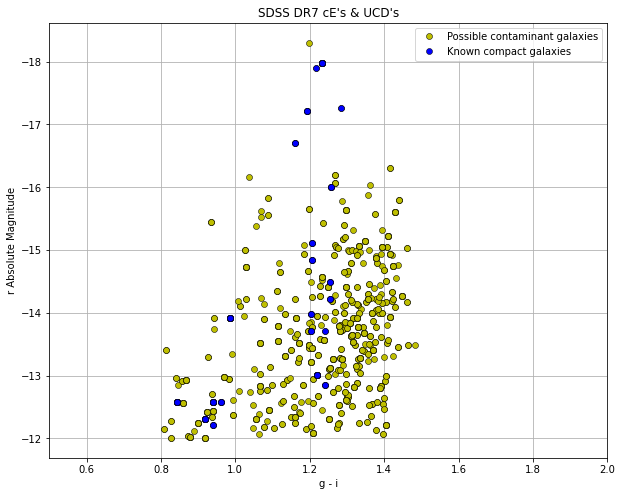

In [12]:
fig1 = plt.figure(figsize=(10,8))

plt.plot(g_i_mag_dr7,mv_r_dr7, 'yo', label = 'Possible contaminant galaxies', markeredgecolor= 'black', markeredgewidth =0.5 , markersize=6)

plt.xlabel('g - i')
plt.ylabel('r Absolute Magnitude')
plt.xlim(0.5,2)
# plt.ylim(-19,-12)
plt.title("SDSS DR7 cE's & UCD's")

plt.plot(g_i_mag_dr7[index_known_dr7],mv_r_dr7[index_known_dr7], 'bo', label = 'Known compact galaxies', markeredgecolor = 'black', markeredgewidth = 0.5, markersize=6)
# plt.plot(g_i_mag_dr7[index_unknown_dr7],mv_r_dr7[index_unknown_dr7], 'ro', label = 'Knsown compact galaxies', markeredgecolor = 'black', markeredgewidth = 0.5, markersize=6)
plt.gca().invert_yaxis()
plt.grid()
plt.legend(loc="upper right")
# plt.savefig('SDSS DR7 cE & UCD.pdf')

In [13]:
print('Total objects (including duplicates):',len(objid_dr7))
objid_filtered_dr7 = []
[objid_filtered_dr7.append(x) for x in objid_dr7 if x not in objid_filtered_dr7]
print('Unique objects:',len(objid_filtered_dr7))
objid_unique_dr7 = np.unique(objid_dr7)

Total objects (including duplicates): 975
Unique objects: 323


In [14]:
# finding index of each unique object
index_unique = []
index_b = []
for i in range(len(objid_filtered_dr7)):
    index_c = []
    index_e = []
    
    index_b = np.where(objid_filtered_dr7[i] == objid_dr7)[0]

    index_b = np.array(index_b)

    index_c.extend(index_b)

    index_e.append(index_c[0])

    
    if len(index_c) > 1:
        index_unique += index_e
    else:
        index_unique += index_c
        
index_unique = np.array(index_unique)

In [15]:
# make a link to sdss for each object
link_dr7 = []
for i in range(len(index_unique)):
    url = 'http://cas.sdss.org/dr7/en/tools/explore/obj.asp?id=' + str(objid_dr7[index_unique][i])
    link_dr7.append(url)

In [16]:
# dictionary of lists  
dict = {'objid': objid_dr7[index_unique], 'ra': ra_dr7[index_unique], 'dec': dec_dr7[index_unique], 'g-i': g_mag_dr7[index_unique] - i_mag_dr7[index_unique], 'u-g': u_mag_dr7[index_unique] - g_mag_dr7[index_unique], 'u-z': u_mag_dr7[index_unique] - z_mag_dr7[index_unique], 'g-z': g_mag_dr7[index_unique] - z_mag_dr7[index_unique], 'g-r': g_mag_dr7[index_unique] - r_mag_dr7[index_unique], 'concentration_index': concentration_index_dr7[index_unique], 'photo_z': z_dr7[index_unique], 'frac_dev': fracdev_dr7[index_unique], 'host_galaxy': host_galaxy_list_dr7[index_unique], 'distance': distance_dr7[index_unique], 'axis_ratio': axis_ratio_dr7[index_unique], 'category': category_dr7[index_unique], 'radius': r_pc_dr7[index_unique], 'magnitude': mv_r_dr7[index_unique], 'u_mag': u_mag_dr7[index_unique], 'g_mag': g_mag_dr7[index_unique], 'i_mag': i_mag_dr7[index_unique], 'r_mag': r_mag_dr7[index_unique], 'z_mag': z_mag_dr7[index_unique],  'link': link_dr7}  
df = pd.DataFrame(dict) 
    
# saving the dataframe 
df.to_csv('photometric_search_dr7.csv') 

In [18]:
df_dr7 = pd.read_csv('photometric_search_dr7.csv')
columnsNamesArr1 = df_dr7.columns.values
column_names1 = list(columnsNamesArr1)
print(column_names1[1:])

['objid', 'ra', 'dec', 'g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'concentration_index', 'photo_z', 'frac_dev', 'host_galaxy', 'distance', 'axis_ratio', 'category', 'radius', 'magnitude', 'u_mag', 'g_mag', 'i_mag', 'r_mag', 'z_mag', 'link']


In [19]:
plt.rcParams.update({'font.size': 20})

<Figure size 720x576 with 0 Axes>

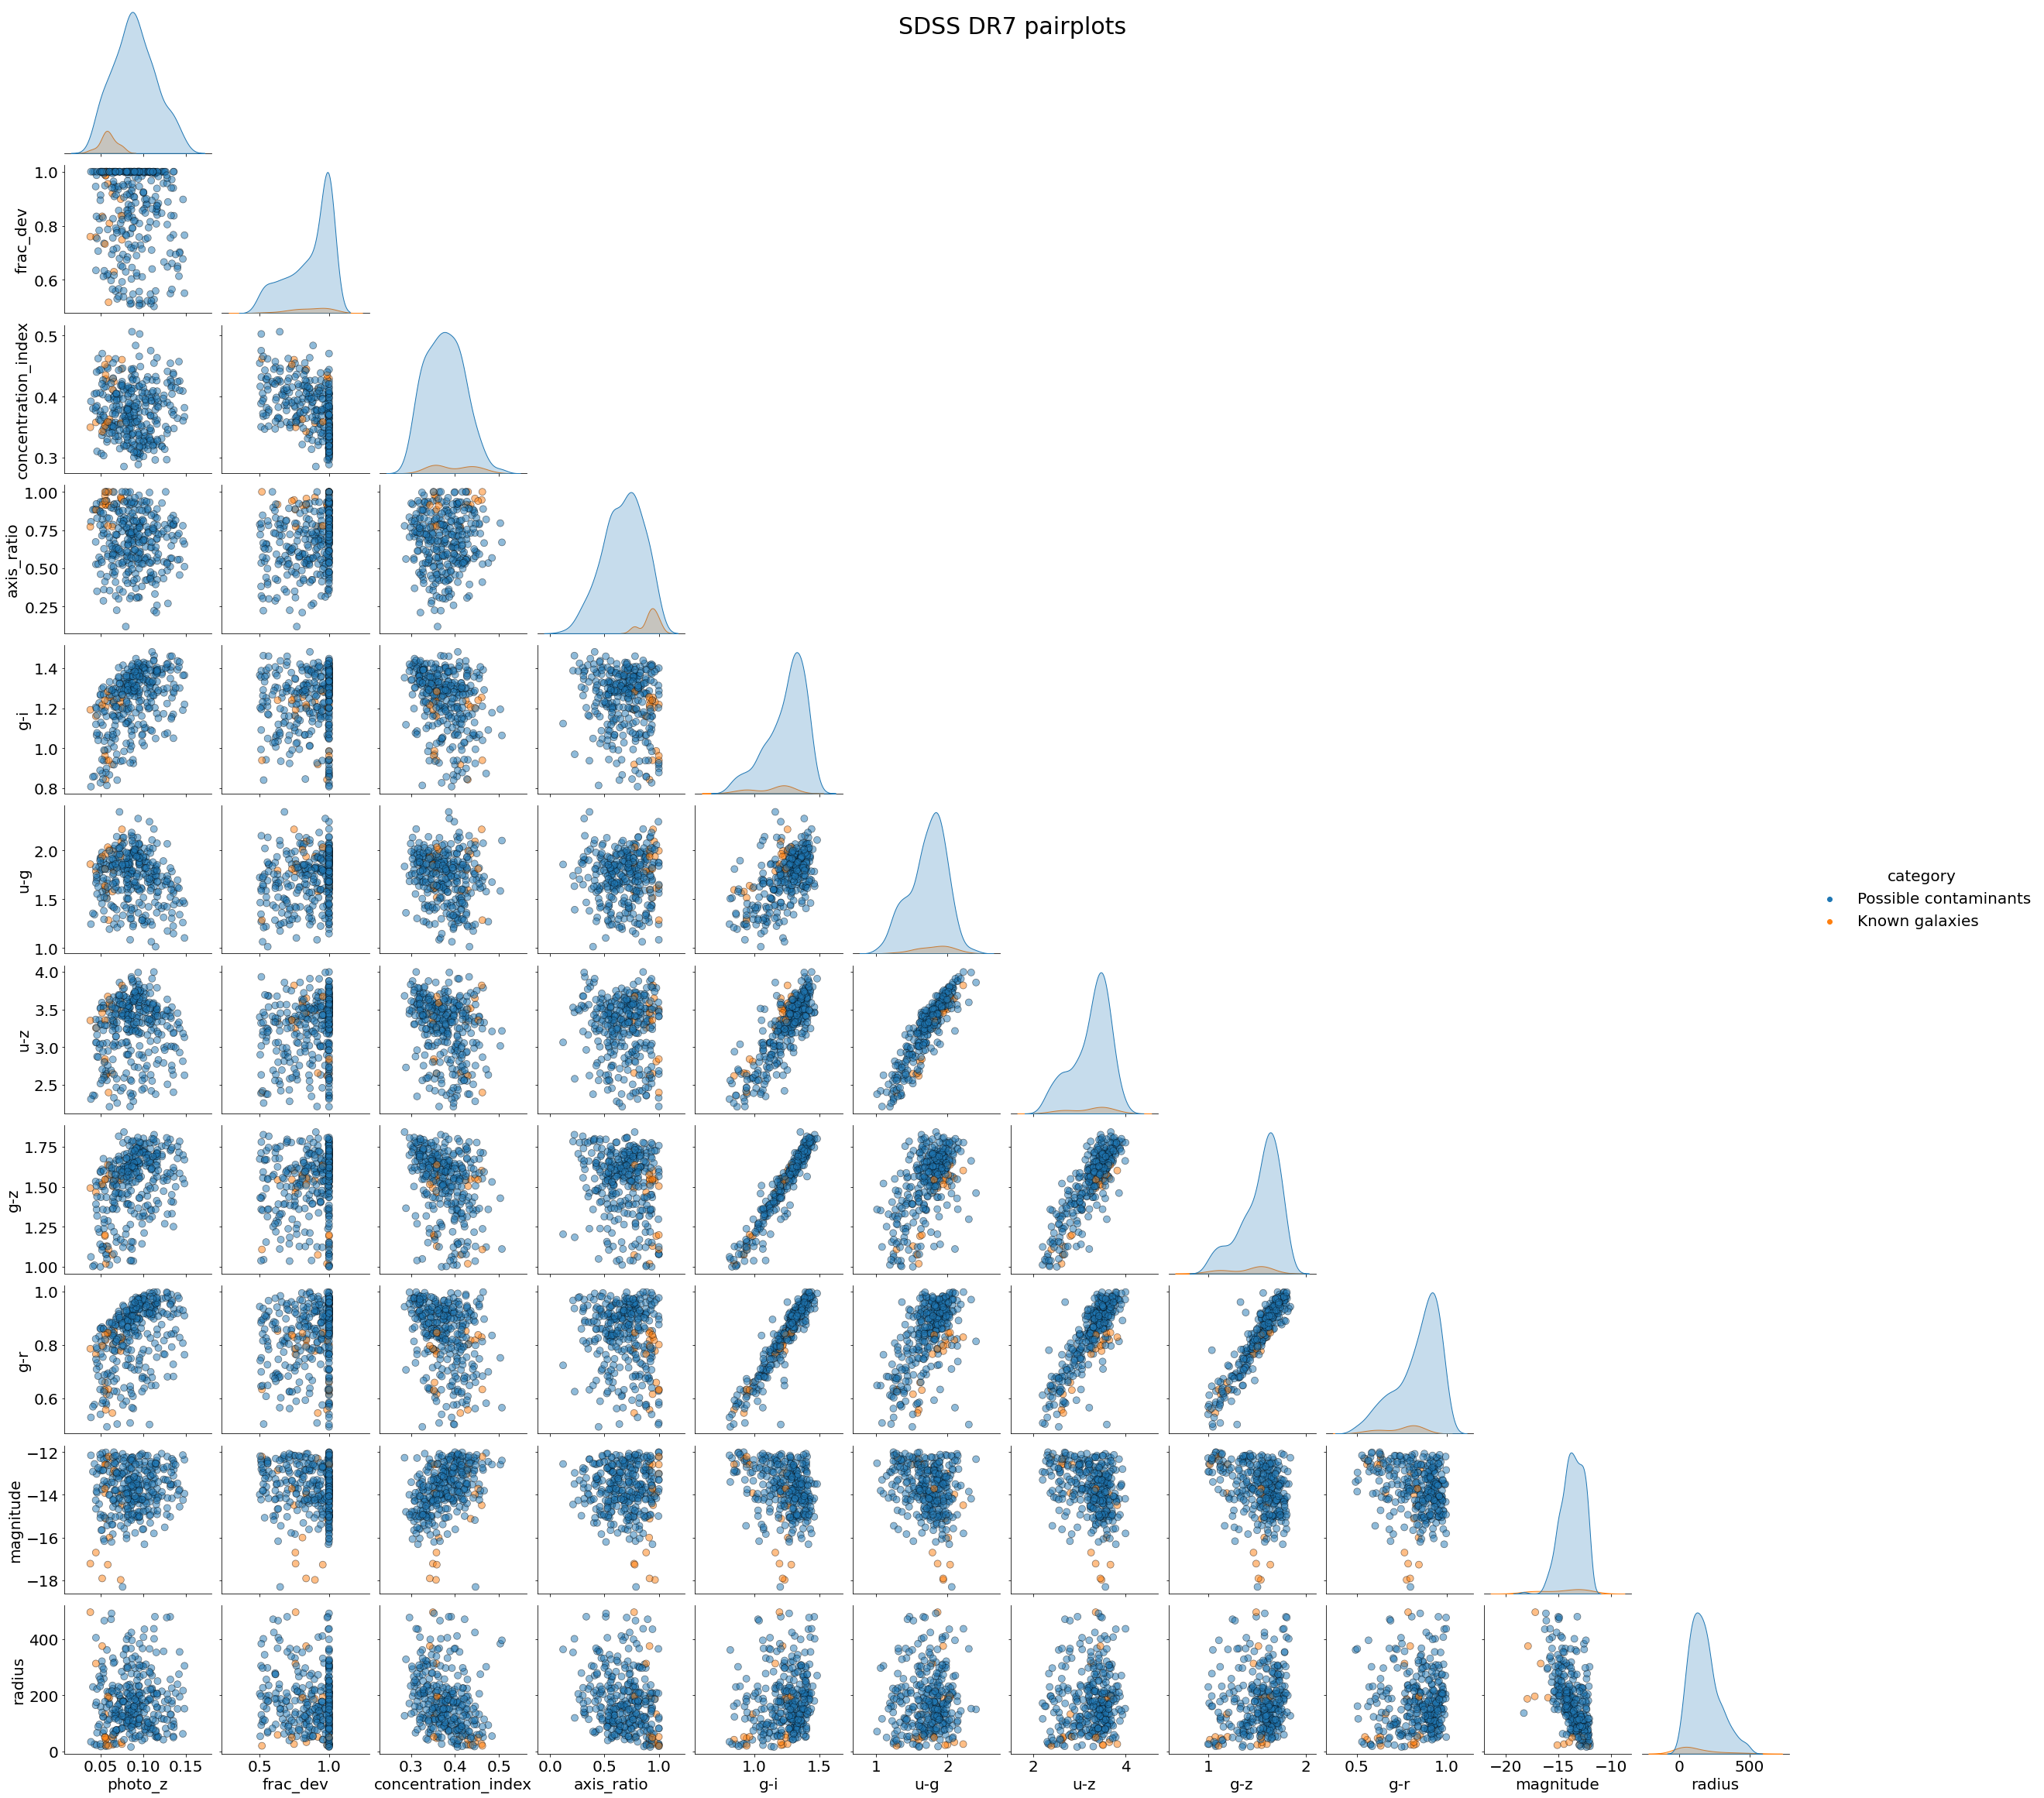

In [21]:
# %matplotlib qt
fig1 = plt.figure(figsize=(10,8))
# sns.set_context("paper", font_scale=2)
# sns.set(font_scale = 1.5)
sns.pairplot(df_dr7, 
             vars = ['photo_z', 'frac_dev', 'concentration_index', 'axis_ratio', 'g-i', 'u-g', 'u-z', 'g-z','g-r','magnitude','radius'],  hue="category",
             corner=True,
             diag_kind = 'kde', 
             plot_kws = {'alpha': 0.5, 's': 80, 'edgecolor': 'k'},
             height=3);
plt.savefig('pairplot_photo_dr7.pdf')
# Title 
plt.suptitle('SDSS DR7 pairplots', 
             size = 30);